# Load the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split   

from tensorflow.keras import models, layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper Functions

In [2]:
def model_evaluate(model, X_test, y_test):
    model = model
    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_int = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_test, y_pred_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['recall'], label='train' + exp_name)
    ax1.plot(history.history['val_recall'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('recall')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    ax3.plot(history.history['loss'], label='train loss'  + exp_name)
    ax3.plot(history.history['val_loss'], label='val loss'  + exp_name)
    ax3.set_title('Loss')
    ax3.legend()
    
    return (ax1, ax2, ax3)

In [4]:
def get_image(item):
#     file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    
    image = Image.open(file_name)
    width, height=image.size
    assert (width==400 and height==400), f"image: {file_name}, width: {width}, height: {height}"
    return np.asarray(image, dtype=np.float32)


# Load Processed Data

### Load meta data

In [5]:
# data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed_Balanced.csv')
data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed.csv')
data = data[data['Cat'].isin(['BCC', 'NV'])]
data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
5,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
6,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0


the shape of the processed data setis (9198, 12)


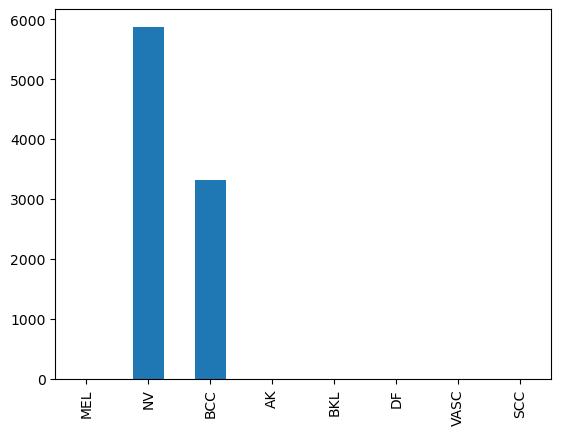

In [6]:
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar();

### Load image data with argumentation

In [24]:
def get_argumented_images(samples):
    result = []
    for i in range(samples.shape[0]):
        item = samples.iloc[i]
        if item['Cat'] == 'AK' or item['Cat'] == 'SCC':
#             print(item['Cat'])
            file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
            image = Image.open(file_name)
            for i in range(3):
                image = image.rotate(90)
                result.append(np.asarray(image, dtype=np.float32))
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            result.append(np.asarray(image, dtype=np.float32))       
    return result

n_samples=3000; 
samples = data.sample(n_samples, random_state=42)
samples_train, samples_test= train_test_split(samples)
print(samples_train.shape, samples_test.shape)

X_train = samples_train.apply(get_image, axis=1)
X_train = np.stack(X_train)
y_train = samples_train.y

argumented_images = get_argumented_images(samples_train)
if len(argumented_images)>0:
    arugmented_train_samples=np.stack(argumented_images)

n_added = arugmented_train_samples.shape[0]
X_train = np.vstack((X_train, arugmented_train_samples))
y_train = pd.Series(list(y_train) + [1] * n_added)

# # sample = data #load the full dataset
print(arugmented_train_samples.shape,n_added)

X_test = samples_test.apply(get_image, axis=1)
X_test = np.stack(X_test)
y_test = samples_test.y
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2250, 12) (750, 12)


ValueError: need at least one array to stack

### Load image with OUT argumentation

In [7]:
# n_samples=3000; 
# sample = data.sample(n_samples, random_state=42)
sample = data #load the full dataset

X = sample.apply(get_image, axis=1)

X = np.stack(X)
y = sample.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6438, 400, 400, 3) (2760, 400, 400, 3) (6438,) (2760,)


# Modeling

## CNN Model

### build CNN Model

In [49]:
def initialize_CNN_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), input_shape = (400,400,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding='same' ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 100, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy', 'Recall'])   

    return model


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_410 (Conv2D)         (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 200, 200, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_411 (Conv2D)         (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_412 (Conv2D)         (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 50, 50, 64)      

### Train CNN Model

In [50]:
model_cnn = initialize_CNN_model()
# model_cnn.summary()

es = EarlyStopping(patience=15, verbose=1)

history = model_cnn.fit(
    X_train, y_train,
    validation_split = 0.3,
    batch_size = 16,
    epochs=200,
    callbacks=[es],
    verbose = 1)

Epoch 1/200
282/282 [==============================] - 38s 130ms/step - loss: 4.2182 - accuracy: 0.6403 - recall: 0.0068 - val_loss: 402.2037 - val_accuracy: 0.3659 - val_recall: 1.0000
Epoch 2/200
282/282 [==============================] - 26s 91ms/step - loss: 11.0918 - accuracy: 0.6396 - recall: 0.0068 - val_loss: 321.0327 - val_accuracy: 0.3659 - val_recall: 1.0000
Epoch 3/200
282/282 [==============================] - 24s 87ms/step - loss: 4.3519 - accuracy: 0.6387 - recall: 0.0055 - val_loss: 581.8310 - val_accuracy: 0.6341 - val_recall: 0.0000e+00
Epoch 4/200
211/282 [=====================>........] - ETA: 5s - loss: 7.3899 - accuracy: 0.5853 - recall: 0.2041

KeyboardInterrupt: 

## VGG16 Transfer Learning

### Build VGG Model

In [45]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

def load_vgg_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def build_vgg_model():

    model = load_vgg_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model

model_vgg = build_vgg_model()
model_vgg.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 12, 512)       14714688  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 200)               14745800  
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 29,460,689
Trainable params: 14,746,001
Non-trainable params: 14,714,688
_________________________________________________________________


### Data Preprocessing

In [47]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Train VGG Model

In [48]:
model = model_vgg

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'max',
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=32,
                    callbacks=[es])



Epoch 1/100
 67/141 [=============>................] - ETA: 40s - loss: 10.0634 - accuracy: 0.5634 - recall: 0.3105

KeyboardInterrupt: 

## ResNET

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_ResNet50_model():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
    return model
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [10]:
def build_ResNet50_model():

    model = load_ResNet50_model()
    model = add_last_layers(model)

    opt = optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model
ResNet50_model = build_ResNet50_model()
ResNet50_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 346112)            0         
                                                                 
 dense_2 (Dense)             (None, 200)               69222600  
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 92,810,513
Trainable params: 69,222,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

Epoch 1/30
141/141 [==============================] - 110s 772ms/step - loss: 18.2319 - accuracy: 0.5451 - recall: 0.3708 - val_loss: 38.7421 - val_accuracy: 0.7650 - val_recall: 0.8163
Epoch 2/30
141/141 [==============================] - 97s 690ms/step - loss: 8.9840 - accuracy: 0.5453 - recall: 0.3702 - val_loss: 38.6392 - val_accuracy: 0.7650 - val_recall: 0.8149
Epoch 3/30
141/141 [==============================] - 97s 687ms/step - loss: 9.6499 - accuracy: 0.5406 - recall: 0.3646 - val_loss: 36.6615 - val_accuracy: 0.7697 - val_recall: 0.7901
Epoch 4/30
141/141 [==============================] - 96s 679ms/step - loss: 6.1856 - accuracy: 0.5422 - recall: 0.3472 - val_loss: 37.8622 - val_accuracy: 0.7676 - val_recall: 0.8032
Epoch 5/30
141/141 [==============================] - 95s 675ms/step - loss: 6.6458 - accuracy: 0.5435 - recall: 0.3578 - val_loss: 37.6598 - val_accuracy: 0.7676 - val_recall: 0.8017
Epoch 6/30
141/141 [==============================] - 95s 674ms/step - loss: 1

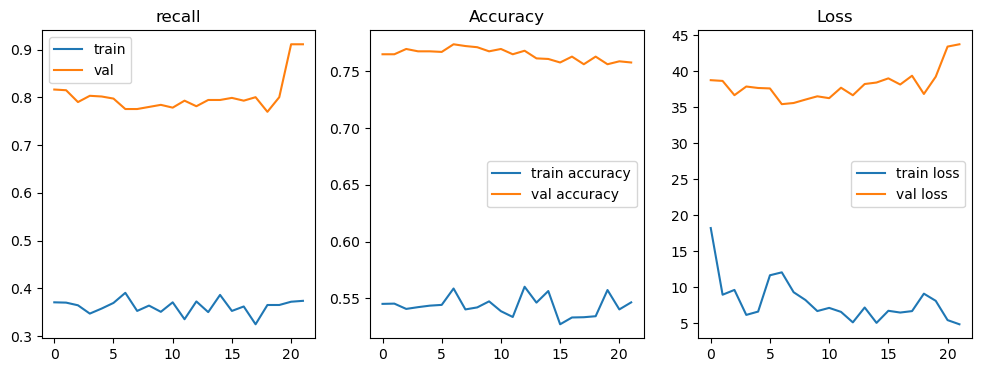

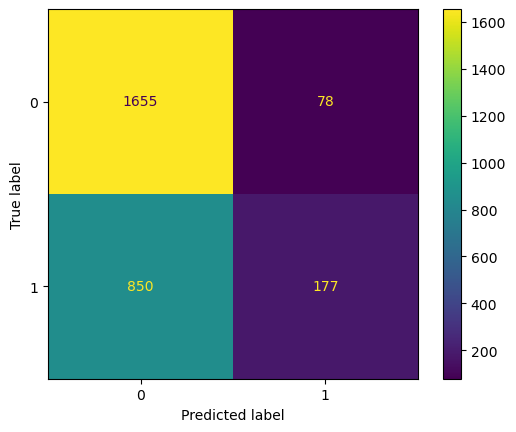

In [13]:
# lr = ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=2,
#     verbose=1,
#     min_lr=0
# )
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)
history = ResNet50_model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=30,
                    batch_size=32,
                    callbacks=[es])

plot_history(history)
model_evaluate(ResNet50_model, X_test, y_test)

## InceptionResNetV2

In [57]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

KeyboardInterrupt: 

In [33]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_InceptionResNetV2_model():
    model = InceptionResNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=X_train[0].shape
    )
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')
    
    augmentation = models.Sequential([
#         layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])
    
    model = models.Sequential(
        [
#             layers.Input(shape=X_train[0].shape),
#             augmentation,
            base_model,
            flatten_layer,
            dense_layer,
            prediction_layer
        ]
    )

    return model

def build_InceptionResNetV2_model():
    model = load_InceptionResNetV2_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    
#     model.compile(optimizer=opt,
#               loss=threshold_binary_crossentropy,
#               metrics=[threshold_accuracy])
    
    return model

Epoch 1/50
141/141 [==============================] - 139s 942ms/step - loss: 5.1251 - accuracy: 0.5342 - recall: 0.3447 - val_loss: 11.4613 - val_accuracy: 0.7055 - val_recall: 0.5546
Epoch 2/50
141/141 [==============================] - 132s 933ms/step - loss: 1.4669 - accuracy: 0.5448 - recall: 0.3698 - val_loss: 41.6967 - val_accuracy: 0.5663 - val_recall: 0.8707
Epoch 3/50
141/141 [==============================] - 131s 932ms/step - loss: 1.3267 - accuracy: 0.5493 - recall: 0.3484 - val_loss: 26.2406 - val_accuracy: 0.7381 - val_recall: 0.4655
Epoch 4/50
141/141 [==============================] - 130s 924ms/step - loss: 4.8674 - accuracy: 0.5335 - recall: 0.3362 - val_loss: 24.4975 - val_accuracy: 0.7371 - val_recall: 0.4713
Epoch 5/50
141/141 [==============================] - 131s 928ms/step - loss: 1.4633 - accuracy: 0.5393 - recall: 0.3435 - val_loss: 25.3813 - val_accuracy: 0.7365 - val_recall: 0.4468
Epoch 6/50
141/141 [==============================] - 131s 933ms/step - los

(<Axes: title={'center': 'recall'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Loss'}>)

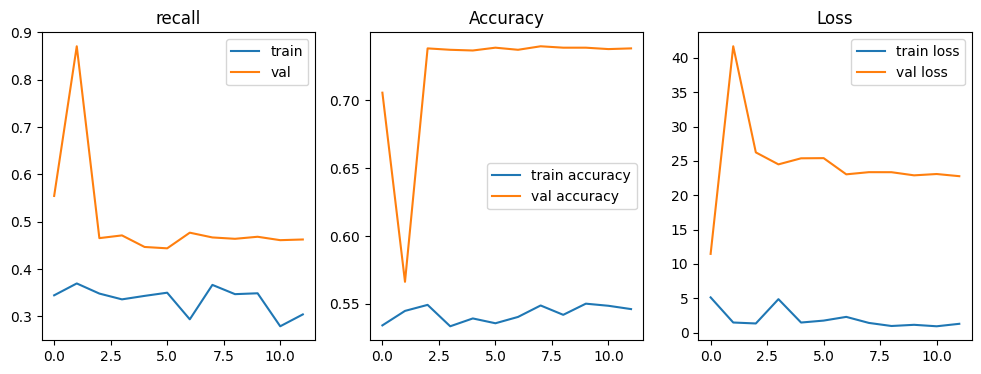

In [34]:
model_InceptionResNetV2 = build_InceptionResNetV2_model()

lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0
)
es = EarlyStopping(
    monitor = 'val_loss',
    mode = 'max',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)
history = model_InceptionResNetV2.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs= 50,
    batch_size=32,
    callbacks=[es]
#     callbacks=[es, lr]
#     callbacks=[lr]
)

plot_history(history)

## InceptionV3

In [60]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [64]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_InceptionResNetV3_model():
    model = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=X_train[0].shape
    )
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')
    
    augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])
    
    model = models.Sequential(
        [
            layers.Input(shape=X_train[0].shape),
            augmentation,
            base_model,
            flatten_layer,
            dense_layer,
            prediction_layer
        ]
    )

    return model

def build_InceptionResNetV3_model():
    model = load_InceptionResNetV3_model()
    model = add_last_layers(model)

    opt = optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    

    return model

Epoch 1/150
141/141 [==============================] - 98s 644ms/step - loss: 22.5278 - accuracy: 0.5311 - recall: 0.3711 - val_loss: 75.3680 - val_accuracy: 0.6454 - val_recall: 0.0104 - lr: 0.0010
Epoch 2/150
141/141 [==============================] - 74s 526ms/step - loss: 2.4657 - accuracy: 0.5371 - recall: 0.3705 - val_loss: 31.9775 - val_accuracy: 0.6082 - val_recall: 0.2582 - lr: 0.0010
Epoch 3/150
141/141 [==============================] - 74s 525ms/step - loss: 3.8759 - accuracy: 0.5399 - recall: 0.3855 - val_loss: 33.7979 - val_accuracy: 0.6713 - val_recall: 0.1239 - lr: 0.0010
Epoch 4/150
141/141 [==============================] - 74s 526ms/step - loss: 2.0453 - accuracy: 0.5282 - recall: 0.3560 - val_loss: 20.0737 - val_accuracy: 0.6739 - val_recall: 0.6761 - lr: 0.0010
Epoch 5/150
141/141 [==============================] - 74s 522ms/step - loss: 3.1868 - accuracy: 0.5297 - recall: 0.3428 - val_loss: 24.1350 - val_accuracy: 0.7076 - val_recall: 0.2881 - lr: 0.0010
Epoch 6/1

(<Axes: title={'center': 'recall'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Loss'}>)

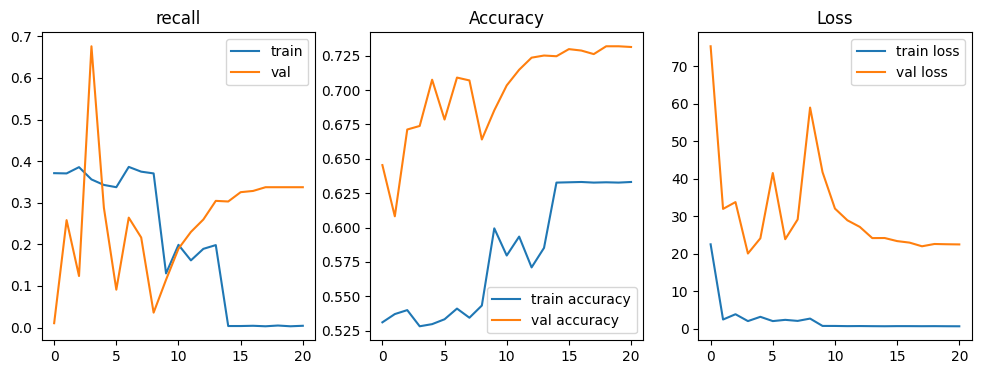

In [65]:
model_InceptionResNetV3 = build_InceptionResNetV3_model()

lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0
)
es = EarlyStopping(
    monitor = 'val_loss',
    mode = 'max',
    patience = 20,
    verbose = 1,
    restore_best_weights = True
)
history = model_InceptionResNetV3.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs= 150,
    batch_size=32,
#     callbacks=[es]
    callbacks=[es, lr]
#     callbacks=[lr]
)

plot_history(history)

## Evaluate Model

87/87 [==============================] - 41s 451ms/step


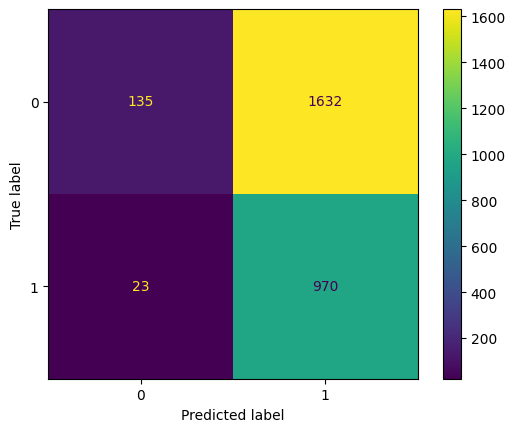

In [43]:
model = ResNet50_model

model_evaluate(ResNet50_model, X_test, y_test)

# Save the trained model

In [ ]:
# Serialize the trained model
model_name= 'InceptionResNetV2'
import pickle
file_name_pickle = f'../result/model_{model_name}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(model, file)